## Aircraft Detection - Inference

In [1]:
import torch
from bbox_utils import *
import torch
from torch import nn
import torch.optim as optimizer
import torch.nn.functional as f
from pathlib import Path
import os
import bbox_utils
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
import pandas as pd
import json
import visualization
import model

In [2]:
new_size = 128
ratio = int(512/new_size)

def resize_bbox_rowwise(row):
    return np.array(bbox_utils.transformsBbox(row['bbox'], ratio), dtype='float64')

def resize_im_rowwise(row):
    return bbox_utils.transformsImg(row['path'], new_size)

In [46]:
#Loading the model

dir_root = os.path.abspath('')
model_dir = Path(dir_root, '../data/model/2022-12-06 10_36_56/model/epoch_5.pth') # replace here the name of the model you want to use

In [4]:
train_imgs = Path(dir_root, '../data/train')
test_imgs = Path(dir_root, '../data/test')
annot_dir = Path(dir_root, '../data/annot/rareplanes.json')

In [5]:
with open(annot_dir) as json_data:
    data = json.load(json_data)

annot_train = pd.DataFrame(data['categories'])
annot_train.drop(['loc_id', 'cat_id', 'location', 'role', 'role_id', 'is_plane', 'num_engines', 'propulsion', 'canards', 'num_tail_fins', 'wing_position', 'wing_type',
                'length', 'wingspan', 'area', 'faa_wingspan_class', 'Public_Train', 'Public_Test', 'partialDec', 'truncated', 'new_area', 'area_pixels', 'id'], axis=1, inplace=True)
annot_train.rename(columns={"image_fname": "name"}, inplace=True)

annot_train = annot_train.groupby(['image_id']).agg(
    tuple).applymap(np.array).reset_index()

annot_train.drop(annot_train.index.to_list()[100:], axis=0, inplace=True)

annot_train['path'] = annot_train.apply(
    lambda row: str(train_imgs) + "/"+row['name'][0], axis=1)
annot_train.drop(['name', 'image_id'], axis=1, inplace=True)

In [6]:
annot_train['image'] = annot_train.apply(resize_im_rowwise, axis=1)
annot_train['bbox'] = annot_train.apply(resize_bbox_rowwise, axis=1)
annot_train.head()

,bbox,path,image
0,"[[0.0, 113.0, 30.0, 127.0]]",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.20588235294117646, 0.17450980392156862, 0..."
1,"[[61.0, 59.0, 73.0, 66.0], [63.0, 0.0, 73.0, 5...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.10392156862745097, 0.09019607843137255, 0..."
2,"[[8.0, 116.0, 39.0, 127.0]]",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.056862745098039215, 0.07352941176470588, ..."
3,"[[26.0, 5.0, 42.0, 18.0], [75.0, 42.0, 86.0, 5...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.403921568627451, 0.34411764705882353, 0.2..."
4,"[[114.0, 59.0, 120.0, 64.0], [123.0, 48.0, 127...",/zhome/3a/d/136926/AIRCRAFT/src/../data/train/...,"[[[0.2519607843137255, 0.20392156862745098, 0...."


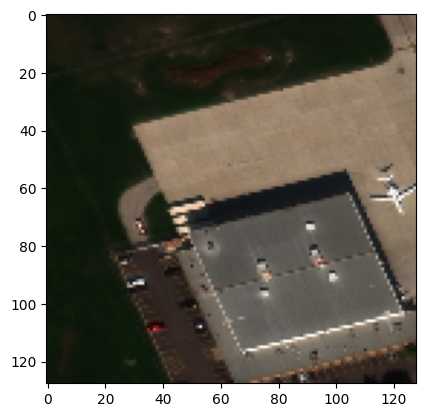

In [7]:
plt.figure()
plt.imshow(annot_train['image'][78])
plt.show()

In [39]:
DEBUG_LAYERS = False

aircraft_model = model.AircraftModel().double()
loaded_model = torch.load(model_dir, map_location = torch.device('cpu'))

if DEBUG_LAYERS:
    print('------------ MODEL FORMAT -------------')
    for layer_name, tensor in aircraft_model.named_parameters():
        print(layer_name, tensor.size())
    print('----------- LOADED MODEL --------------')
    for layer_name, tensor in loaded_model.named_parameters():
        print(layer_name, tensor.size())


#model.load_state_dict(loaded_model.state_dict())
aircraft_model.load_state_dict(loaded_model)
aircraft_model.eval()

AircraftModel(
  (conv): Sequential(
    (0): Conv2d(3, 192, kernel_size=(7, 7), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (9): LeakyReLU(negative_slope=0.1)
    (10): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (13): LeakyReLU(negative_slope=0.1)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (16): LeakyReLU(negative_slope=0.1)
    (1

In [57]:
import training_utilities

# import importlib
# importlib.reload(training_utilities)

image_index = 90
# Confidence equal to, or higher gets shown
THRESHHOLD = 0.07

inputs = torch.from_numpy(np.array([annot_train['image'][image_index]]))
inputs = torch.permute(inputs, (0, 3, 1, 2))

output = aircraft_model(inputs)
targets = training_utilities.calculate_iou(annot_train['bbox'][image_index])
loss = training_utilities.loss_fn(output, torch.from_numpy(np.array([targets])))

print('Loss', loss.item())
plane_count = (output.detach().numpy() >= THRESHHOLD).sum()

# print("Output: ",output)
print('expected planes: ', targets.sum())
print("Planes found: ", plane_count) #when the model outputs proper 1's and 0'2 this should make more sense

Loss 0.03704474373265451
expected planes:  1.0
Planes found:  2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


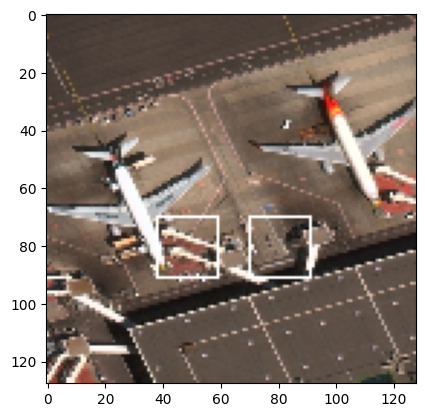

In [54]:
visualization.display_bbox_target_vector(annot_train['image'][image_index], output[0], model.np_bboxs, THRESHHOLD)